# Developing an AI application

앞으로 AI 알고리즘은 점점 더 많은 일상적인 애플리케이션에 통합될 것입니다. 예를 들어, 스마트폰 앱에 이미지 분류기를 포함하고 싶을 수도 있습니다. 이를 위해 수십만 개의 이미지로 학습된 딥러닝 모델을 전체 애플리케이션 아키텍처의 일부로 사용할 수 있습니다. 미래의 소프트웨어 개발에서 이러한 유형의 모델은 애플리케이션의 일반적인 구성 요소로 널리 사용될 것입니다. 

이 프로젝트에서는 다양한 꽃의 종을 인식할 수 있는 이미지 분류기를 학습하게 됩니다. 이를 활용하면 스마트폰 앱에서 카메라로 촬영한 꽃의 이름을 알려주는 기능을 구현할 수 있습니다. 실용적인 활용을 위해, 먼저 분류기를 학습한 후 이를 애플리케이션에서 사용할 수 있도록 내보낼 것입니다. 우리는 [이 데이터셋](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)을 사용할 것이며, 102개의 꽃 종류가 포함되어 있습니다. 아래에서 몇 가지 예시를 확인할 수 있습니다.

<img src='assets/Flowers.png' width=500px>

이 프로젝트는 여러 단계로 나누어집니다:

* 이미지 데이터셋 로드 및 전처리
* 데이터셋을 사용한 이미지 분류기 학습
* 학습된 분류기를 사용하여 이미지 내용 예측

각 단계를 Python으로 구현할 수 있도록 안내할 것입니다.

이 프로젝트를 완료하면, 어떤 라벨이 지정된 이미지 세트에도 학습할 수 있는 애플리케이션을 갖게 됩니다. 여기서는 네트워크가 꽃을 학습하여 명령줄 애플리케이션으로 끝나겠지만, 새로운 기술을 어떻게 활용할지는 여러분의 상상력과 데이터셋 구축 노력에 달려 있습니다. 예를 들어, 자동차 사진을 찍으면 제조사와 모델을 식별하고 관련 정보를 찾아주는 앱을 만든다고 상상해 보세요. 직접 데이터셋을 만들어 새로운 것을 개발해 보세요.

먼저 필요한 패키지를 가져오는 것으로 시작하겠습니다. 코드의 시작 부분에 모든 import 문을 작성하는 것이 좋은 습관입니다. 노트북을 진행하면서 필요한 패키지가 있으면, 이곳에 import 문을 추가하세요.

In [53]:
# Imports here
# Basic Python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch imports
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

# Image processing
from PIL import Image

# Utility
from collections import OrderedDict

## 데이터 로드하기

여기서는 `torchvision`을 사용하여 데이터를 로드합니다 ([문서 참고](http://pytorch.org/docs/0.3.0/torchvision/index.html)). 데이터는 이 노트북과 함께 제공되어야 하지만, 그렇지 않은 경우 [여기에서 다운로드할 수 있습니다](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

데이터셋은 학습(training), 검증(validation), 테스트(testing) 세 부분으로 나누어집니다. 학습 데이터에는 랜덤 크기 조정, 자르기(cropping), 뒤집기(flipping) 등의 변환을 적용하는 것이 좋습니다. 이러한 변환을 통해 네트워크가 일반화(generalization) 능력을 갖추어 더 나은 성능을 발휘할 수 있습니다. 또한, 사전 학습된 네트워크의 요구 사항에 맞게 입력 데이터를 **224x224 픽셀**로 조정해야 합니다.

검증 및 테스트 세트는 네트워크가 한 번도 본 적 없는 데이터에 대한 성능을 평가하는 데 사용됩니다. 따라서 이 데이터에는 크기 조정(scaling)이나 회전(rotation)과 같은 변환을 적용하지 않는 것이 좋습니다. 대신, 적절한 크기로 이미지를 조정한 후 중앙을 자르는(cropping) 방식으로 전처리를 수행해야 합니다.

사용할 사전 학습된 네트워크는 ImageNet 데이터셋에서 학습되었습니다. 이 데이터셋에서는 각 색상 채널을 개별적으로 정규화(normalization)합니다. 따라서 세 가지 데이터셋(학습, 검증, 테스트)에 대해 네트워크가 기대하는 평균과 표준 편차를 맞춰야 합니다. 

- **평균(mean):** `[0.485, 0.456, 0.406]`
- **표준 편차(std):** `[0.229, 0.224, 0.225]`

이 값들은 ImageNet 데이터에서 계산된 것으로, 각 색상 채널을 0을 중심으로 하고 값의 범위를 -1에서 1 사이로 조정하는 역할을 합니다.

 

In [37]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                           [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                           [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                           [0.229, 0.224, 0.225])
    ])
}

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=32),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32)
}

### 라벨 매핑

카테고리 라벨을 카테고리 이름으로 매핑하는 데이터도 로드해야 합니다. 이는 `cat_to_name.json` 파일에서 찾을 수 있습니다. 해당 파일은 [`json` 모듈](https://docs.python.org/2/library/json.html)을 사용하여 읽을 수 있는 JSON 객체입니다. 이를 통해 정수로 인코딩된 카테고리를 실제 꽃 이름과 매핑하는 딕셔너리를 얻을 수 있습니다.


In [39]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 분류기 구축 및 학습

이제 데이터가 준비되었으므로, 분류기를 구축하고 학습시킬 차례입니다. 일반적으로 `torchvision.models`에서 사전 학습된 모델을 사용하여 이미지 특징을 추출해야 합니다. 그런 다음, 이러한 특징을 활용하여 새로운 피드포워드 분류기를 구축하고 학습하세요.

이 부분은 여러분이 직접 수행해야 합니다. 성공적으로 이 단계를 완료하는 방법에 대한 가이드는 [평가기준](https://review.udacity.com/#!/rubrics/1663/view)을 참고하세요. 수행해야 할 작업은 다음과 같습니다.

* [사전 학습된 네트워크](http://pytorch.org/docs/master/torchvision/models.html) 로드 (시작점을 찾고 있다면 VGG 네트워크가 좋은 선택이며 사용하기 쉽습니다)
* ReLU 활성화 함수와 드롭아웃을 사용하는 새로운 미학습 피드포워드 네트워크를 분류기로 정의
* 사전 학습된 네트워크에서 특징을 추출한 후, 역전파를 사용하여 분류기 계층을 학습
* 검증 세트에서 손실 및 정확도를 추적하여 최적의 하이퍼파라미터 결정

아래에 코드를 작성할 수 있는 빈 셀이 제공되었지만, 필요한 만큼 여러 개의 셀을 사용하세요. 문제를 더 작은 부분으로 나누어 실행하는 것이 좋습니다. 각 부분이 예상대로 작동하는지 확인한 후 다음 단계로 진행하세요. 아마도 진행하면서 이전 코드로 돌아가 수정해야 할 일이 생길 것입니다. 이는 지극히 정상적인 과정입니다.

학습할 때는 피드포워드 네트워크의 가중치만 업데이트되도록 해야 합니다. 모든 것을 올바르게 구축하면 검증 정확도를 70% 이상 달성할 수 있습니다. 최상의 모델을 찾기 위해 다양한 하이퍼파라미터(학습률, 분류기 유닛 수, 에포크 수 등)를 실험해 보세요. 이 프로젝트의 다음 단계에서 기본값으로 사용할 수 있도록 최적의 하이퍼파라미터를 저장하세요.

마지막으로, 워크스페이스에서 코드를 실행하는 경우 중요한 팁이 있습니다. 이 노트북에서 실행되는 장기 작업 중에 워크스페이스 연결이 끊어지는 것을 방지하려면, 이 강의의 초반에 있는 **GPU 워크스페이스 소개 및 세션 유지 방법**을 읽어보세요. `workspace_utils.py` 모듈의 코드를 포함하면 유용할 것입니다.

**워크스페이스 사용자 참고:** 체크포인트로 저장된 네트워크 크기가 1GB를 초과하는 경우, 백업 저장에 문제가 발생할 수 있습니다. 일반적으로 이는 합성곱 계층 이후에 넓은 밀집 계층을 사용하는 경우 발생합니다. 저장된 체크포인트 파일 크기가 1GB를 초과한다면(터미널에서 `ls -lh` 명령어로 확인 가능), 숨겨진 계층의 크기를 줄이고 다시 학습하는 것이 좋습니다.


In [40]:
# TODO: Build and train your network
# 사전 학습된 VGG16 모델 불러오기
# VGG16 모델은 ImageNet 데이터셋에서 학습된 모델로, 이미지 분류 문제에 많이 사용되는 모델 중 하나입니다.
model = models.vgg16(pretrained=True)

# 모델의 모든 파라미터를 고정 (Gradient 업데이트 방지)
# 즉, 사전 학습된 가중치를 그대로 사용하고 새로운 가중치는 업데이트하지 않음
for param in model.parameters():
    param.requires_grad = False

# 새로운 분류기 정의
# OrderedDict를 사용하여 순차적인 레이어를 정의
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 4096)),  # 첫 번째 완전연결층 (VGG16의 특징 맵 25088개를 입력으로 받아 4096개 출력)
    ('relu1', nn.ReLU()),             # 활성화 함수 ReLU 적용
    ('dropout1', nn.Dropout(p=0.5)),  # 과적합 방지를 위한 드롭아웃 (50% 확률로 뉴런 비활성화)
    ('fc2', nn.Linear(4096, 1024)),   # 두 번째 완전연결층 (4096 -> 1024)
    ('relu2', nn.ReLU()),             # 활성화 함수 ReLU 적용
    ('dropout2', nn.Dropout(p=0.5)),  # 과적합 방지를 위한 드롭아웃
    ('fc3', nn.Linear(1024, 102)),    # 마지막 출력층 (1024 -> 102), 102는 꽃의 카테고리 수
    ('output', nn.LogSoftmax(dim=1))  # 로그 소프트맥스(LogSoftmax) 적용 (확률 형태의 출력)
]))

# 기존 VGG16 모델의 classifier 부분을 새로 정의한 classifier로 교체
model.classifier = classifier

# 손실 함수(Negative Log Likelihood Loss) 및 옵티마이저(Adam) 정의
# NLLLoss는 LogSoftmax가 적용된 출력에 적합한 손실 함수
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Adam 옵티마이저 사용, 학습률 0.001

In [41]:
# GPU 사용 가능하면 GPU로 모델 이동, 그렇지 않으면 CPU 사용
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
epochs = 5  # 총 5번의 학습 반복 (epoch)
steps = 0  # 학습 진행을 추적하는 변수
running_loss = 0  # 현재 학습 중인 손실값 누적
print_every = 5  # 5 스텝마다 진행 상황 출력

In [43]:
# 모델 학습 시작
for epoch in range(epochs):  # 지정한 epoch 수만큼 반복
    for inputs, labels in dataloaders['train']:  # 훈련 데이터 로드
        steps += 1
        
        # 입력 데이터와 라벨을 GPU/CPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # 그래디언트 초기화 (이전 값이 누적되지 않도록)

        logps = model.forward(inputs)  # 모델의 순전파(forward propagation)
        loss = criterion(logps, labels)  # 손실 계산
        loss.backward()  # 역전파(backpropagation) - 그래디언트 계산
        optimizer.step()  # 옵티마이저를 사용하여 가중치 업데이트

        running_loss += loss.item()  # 손실값 누적

        # 일정한 스텝마다 검증(validation) 진행
        if steps % print_every == 0:
            valid_loss = 0  # 검증 손실값 초기화
            accuracy = 0  # 정확도 초기화
            model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 등이 비활성화됨)

            with torch.no_grad():  # 검증 과정에서는 그래디언트 계산을 비활성화하여 메모리 절약
                for inputs, labels in dataloaders['valid']:  # 검증 데이터 로드
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)  # 모델의 순전파 실행
                    batch_loss = criterion(logps, labels)  # 검증 손실 계산
                    valid_loss += batch_loss.item()  # 검증 손실값 누적

                    # 정확도 계산
                    ps = torch.exp(logps)  # 로그 소프트맥스를 지수 변환하여 확률 값으로 복원
                    top_p, top_class = ps.topk(1, dim=1)  # 가장 확률이 높은 클래스(top-1) 찾기
                    equals = top_class == labels.view(*top_class.shape)  # 예측과 실제 라벨 비교
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()  # 평균 정확도 계산

            # 학습 및 검증 결과 출력
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "  # 평균 학습 손실 출력
                  f"Validation loss: {valid_loss/len(dataloaders['valid']):.3f}.. "  # 평균 검증 손실 출력
                  f"Validation accuracy: {accuracy/len(dataloaders['valid']):.3f}")  # 평균 검증 정확도 출력
            
            running_loss = 0  # 학습 손실값 초기화
            model.train()  # 모델을 다시 학습 모드로 전환 (dropout, batchnorm 활성화)

KeyboardInterrupt: 

## 네트워크 테스트하기

훈련된 네트워크를 테스트 데이터로 검증하는 것은 좋은 연습 방법입니다. 테스트 데이터는 학습 및 검증 과정에서 한 번도 본 적이 없는 이미지로 구성됩니다. 이를 통해 완전히 새로운 이미지에 대한 모델의 성능을 추정할 수 있습니다. 테스트 이미지를 네트워크에 입력하고, 검증을 수행했던 방식과 동일하게 정확도를 측정하세요. 모델이 잘 훈련되었다면, 테스트 세트에서 약 70%의 정확도를 달성할 수 있을 것입니다.


In [44]:
# TODO: Do validation on the test set
def test_model(model, testloader, criterion, device):
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 테스트 손실과 정확도 초기화
    test_loss = 0
    accuracy = 0
    
    # Inference 모드 (no_grad)
    with torch.no_grad():
        for inputs, labels in testloader:
            # 데이터를 device로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            
            # 정확도 계산
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    # 평균 손실과 정확도 계산
    avg_test_loss = test_loss/len(testloader)
    avg_accuracy = accuracy/len(testloader)
    
    print(f"Test Results:\n",
          f"Test Loss: {avg_test_loss:.3f}\n",
          f"Test Accuracy: {avg_accuracy:.3f}")
    
    return avg_test_loss, avg_accuracy

# 테스트 실행
test_loss, test_accuracy = test_model(model, dataloaders['test'], criterion, device)

Test Results:
 Test Loss: 5.809
 Test Accuracy: 0.041


## 체크포인트 저장하기

이제 네트워크가 학습되었으므로, 나중에 예측을 수행할 수 있도록 모델을 저장하세요. 또한, 클래스와 인덱스 간의 매핑 정보도 함께 저장하는 것이 좋습니다. 이 정보는 `image_datasets['train'].class_to_idx`에서 얻을 수 있습니다. 나중에 추론을 더 쉽게 수행할 수 있도록 이 매핑 정보를 모델의 속성으로 추가할 수 있습니다.

```model.class_to_idx = image_datasets['train'].class_to_idx```

나중에 모델을 완전히 재구성하여 추론에 사용할 수 있도록 필요한 정보를 체크포인트에 포함해야 합니다. 만약 모델을 불러와 추가 학습을 진행하고 싶다면, 학습한 에포크 수와 옵티마이저 상태(`optimizer.state_dict`)도 저장해야 합니다. 이 모델은 프로젝트의 다음 단계에서 활용될 가능성이 높으므로, 지금 저장해 두는 것이 좋습니다.


In [45]:
# TODO: Save the checkpoint 
# 클래스와 인덱스 매핑 정보를 모델에 추가
model.class_to_idx = image_datasets['train'].class_to_idx

# 체크포인트 저장
checkpoint = {
    'arch': 'vgg16',
    'input_size': 25088,
    'output_size': 102,
    'hidden_layers': [4096, 1024],
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx,
    'optimizer_state': optimizer.state_dict(),
    'epochs': epochs
}

torch.save(checkpoint, 'checkpoint.pth')

## 체크포인트 불러오기

이제 체크포인트를 로드하고 모델을 재구성할 수 있는 함수를 작성하는 것이 좋습니다. 이렇게 하면 나중에 이 프로젝트로 돌아와 네트워크를 다시 학습할 필요 없이 계속 작업을 이어갈 수 있습니다.


In [46]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
# 체크포인트 로드 함수
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    # 모델 재구성
    model = models.vgg16(pretrained=True)
    
    # 분류기 재구성
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(checkpoint['input_size'], checkpoint['hidden_layers'][0])),
        ('relu1', nn.ReLU()),
        ('dropout1', nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(checkpoint['hidden_layers'][0], checkpoint['hidden_layers'][1])),
        ('relu2', nn.ReLU()),
        ('dropout2', nn.Dropout(p=0.5)),
        ('fc3', nn.Linear(checkpoint['hidden_layers'][1], checkpoint['output_size'])),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    # 모델에 분류기 설정
    model.classifier = classifier
    
    # 상태 딕셔너리 로드
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

# 체크포인트 로드 테스트
loaded_model = load_checkpoint('checkpoint.pth')

# 분류를 위한 추론 (Inference for classification)

이제 학습된 네트워크를 사용하여 추론을 수행하는 함수를 작성할 것입니다. 즉, 이미지를 네트워크에 입력하고, 해당 이미지가 어떤 꽃인지 예측하는 기능을 구현합니다. `predict`라는 함수를 작성하여 이미지와 모델을 입력으로 받고, 가장 가능성이 높은 $K$개의 클래스와 확률을 반환하도록 만드세요. 함수 사용 예시는 다음과 같습니다.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```


먼저 입력 이미지를 네트워크에서 사용할 수 있도록 처리해야 합니다.

## 이미지 전처리

이미지를 로드할 때 `PIL`을 사용하는 것이 좋습니다 ([문서 참고](https://pillow.readthedocs.io/en/latest/reference/Image.html)). 모델의 입력으로 사용할 수 있도록 이미지를 전처리하는 함수를 작성하는 것이 가장 좋습니다. 이 함수는 학습할 때 사용한 방식과 동일한 방식으로 이미지를 처리해야 합니다.

먼저, 이미지의 짧은 변이 256픽셀이 되도록 비율을 유지하면서 크기를 조정하세요. 이는 [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 또는 [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) 메서드를 사용하여 수행할 수 있습니다. 그 후, 이미지의 중앙 224x224 영역을 잘라내야 합니다.

이미지의 색상 채널은 일반적으로 0~255 범위의 정수로 인코딩되지만, 모델은 0~1 범위의 부동 소수점 값을 기대합니다. 따라서 값을 변환해야 합니다. 변환하는 가장 쉬운 방법은 Numpy 배열을 사용하는 것입니다. PIL 이미지를 Numpy 배열로 변환하려면 다음과 같이 하면 됩니다: `np_image = np.array(pil_image)`.

이전과 마찬가지로, 네트워크는 이미지를 특정 방식으로 정규화하기를 기대합니다. 평균값은 `[0.485, 0.456, 0.406]`이고 표준 편차는 `[0.229, 0.224, 0.225]`입니다. 각 색상 채널에서 평균을 빼고 표준 편차로 나누어 정규화해야 합니다.

마지막으로, PyTorch는 색상 채널이 첫 번째 차원에 위치하는 것을 기대하지만, PIL 이미지와 Numpy 배열에서는 세 번째 차원에 위치합니다. 따라서 차원의 순서를 변경해야 합니다. 이를 위해 [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html) 메서드를 사용할 수 있습니다. 색상 채널을 첫 번째 차원으로 이동시키면서 나머지 두 차원의 순서를 유지해야 합니다.


In [47]:
def process_image(image_path):
    ''' 
    PIL 이미지를 PyTorch 모델에 맞게 처리하는 함수
    
    Parameters:
        image_path (str): 처리할 이미지의 파일 경로
        
    Returns:
        torch.Tensor: 전처리된 이미지 텐서 (shape: [3, 224, 224])
    '''
    # PIL 이미지 로드
    img = Image.open(image_path)
    
    # 이미지 크기 조정을 위한 처리
    if img.size[0] > img.size[1]:
        ratio = 256 / img.size[1]
    else:
        ratio = 256 / img.size[0]
    new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
    
    # 비율을 유지하면서 짧은 변이 256픽셀이 되도록 크기 조정
    img = img.resize(new_size)
    
    # 중앙 부분 224x224 크롭
    left = (img.size[0] - 224) / 2
    top = (img.size[1] - 224) / 2
    right = left + 224
    bottom = top + 224
    img = img.crop((left, top, right, bottom))
    
    # PIL 이미지를 numpy 배열로 변환 (0-255)
    np_image = np.array(img)
    
    # 값의 범위를 0-1로 변환
    np_image = np_image / 255.0
    
    # 평균과 표준편차로 정규화
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # 색상 채널을 첫 번째 차원으로 이동 (H,W,C) -> (C,H,W)
    np_image = np_image.transpose((2, 0, 1))
    
    # numpy 배열을 PyTorch 텐서로 변환
    torch_image = torch.from_numpy(np_image).type(torch.FloatTensor)
    
    return torch_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [48]:
def imshow(image, ax=None, title=None):
    """
    PyTorch 텐서를 matplotlib을 사용하여 이미지로 표시하는 함수
    
    Parameters:
        image (torch.Tensor): 표시할 이미지 텐서
        ax (matplotlib.axes.Axes, optional): 그림을 그릴 축 객체
        title (str, optional): 이미지 위에 표시할 제목
    
    Returns:
        matplotlib.axes.Axes: 이미지가 그려진 축 객체
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch 텐서는 색상 채널이 첫 번째 차원
    # matplotlib은 색상 채널이 마지막 차원이어야 함
    image = image.numpy().transpose((1, 2, 0))
    
    # 정규화 해제
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # 이미지 값을 0과 1 사이로 클리핑
    image = np.clip(image, 0, 1)
    
    # 이미지 표시
    ax.imshow(image)
    
    # 제목 설정
    if title:
        ax.set_title(title)
    
    # 축 눈금 제거
    ax.axis('off')
    
    return ax

## 클래스 예측

이미지가 올바른 형식으로 준비되면, 모델로 예측을 수행하는 함수를 작성할 차례입니다. 일반적인 방법은 가장 확률이 높은 상위 5개(보통 top-$K$라고 부름)의 클래스를 예측하는 것입니다. 먼저 클래스 확률을 계산한 후, 상위 $K$개의 값을 찾아야 합니다.

텐서에서 상위 $K$개의 값을 얻으려면 [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk)를 사용하세요. 이 메소드는 가장 높은 `k`개의 확률과 해당 확률에 해당하는 클래스의 인덱스를 모두 반환합니다. 이 인덱스를 실제 클래스 레이블로 변환하려면, 모델에 추가해 두었거나 데이터를 로드할 때 사용한 `ImageFolder`로부터 얻은 `class_to_idx`를 사용하면 됩니다 ([자세한 내용은 여기](#Save-the-checkpoint)을 참고). 인덱스에서 클래스에 대한 매핑을 얻기 위해 사전을 반전(invert)하는 것도 잊지 마세요.

다시 말해, 이 메소드는 이미지 경로와 모델 체크포인트를 입력받아, 확률과 클래스를 반환해야 합니다.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [49]:
def predict(image_path, model, topk=5):
    ''' 
    학습된 딥러닝 모델을 사용하여 이미지의 클래스를 예측하는 함수
    
    Parameters:
        image_path (str): 예측할 이미지의 경로
        model (torch.nn.Module): 학습된 PyTorch 모델
        topk (int): 반환할 상위 예측 개수 (기본값: 5)
    
    Returns:
        tuple: (상위 k개 확률, 해당 클래스 레이블)
    '''
    # 모델을 평가 모드로 설정
    model.eval()
    
    # 이미지 전처리
    image = process_image(image_path)
    
    # GPU 사용 가능하면 GPU로 이동
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    
    # 배치 차원 추가 및 device로 이동
    image = image.unsqueeze(0).to(device)
    
    # 그래디언트 계산 비활성화
    with torch.no_grad():
        # 모델을 통한 예측
        output = model.forward(image)
        
        # 로그 확률을 일반 확률로 변환
        ps = torch.exp(output)
        
        # 상위 k개 확률과 클래스 인덱스 가져오기
        top_p, top_indices = ps.topk(topk, dim=1)
        
        # CPU로 이동하고 numpy 배열로 변환
        top_p = top_p.cpu().numpy().squeeze()
        top_indices = top_indices.cpu().numpy().squeeze()
        
        # 인덱스를 클래스로 매핑하기 위해 class_to_idx의 역매핑 생성
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        
        # 인덱스를 실제 클래스 레이블로 변환
        top_classes = [idx_to_class[idx] for idx in top_indices]
    
    return top_p, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

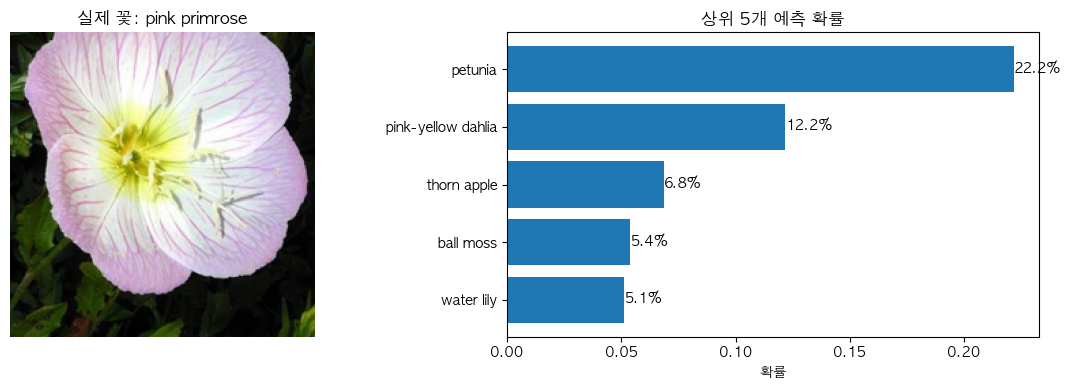

In [52]:
def plot_prediction(image_path, model):
    '''
    이미지와 예측 결과를 시각화하는 함수
    
    Parameters:
        image_path (str): 예측할 이미지의 경로
        model (torch.nn.Module): 학습된 PyTorch 모델
    '''
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'AppleGothic'  # Mac OS용
    # Windows의 경우: 'Malgun Gothic'
    # Linux의 경우: 'NanumGothic'
    
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    
    # 이미지 로드 및 예측 수행
    img = process_image(image_path)
    probs, classes = predict(image_path, model)
    
    # 클래스 인덱스를 실제 꽃 이름으로 변환
    flower_names = [cat_to_name[cls] for cls in classes]
    
    # 서브플롯 생성 (이미지용 1개, 막대 그래프용 1개)
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
    
    # 이미지 표시
    imshow(img, ax=ax1, title=f'실제 꽃: {cat_to_name[image_path.split("/")[-2]]}')
    
    # 막대 그래프 생성
    bars = ax2.barh(np.arange(len(probs)), probs)
    ax2.set_yticks(np.arange(len(probs)))
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # 확률이 높은 순서대로 위에서 아래로 표시
    
    # 막대 그래프에 확률값 표시
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width, bar.get_y() + bar.get_height()/2,
                f'{width*100:.1f}%',
                ha='left', va='center', fontsize=10)
    
    # 그래프 제목과 레이블 설정
    ax2.set_title('상위 5개 예측 확률')
    ax2.set_xlabel('확률')
    
    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

# 예시 이미지로 테스트
test_image = 'flowers/test/1/image_06743.jpg'
plot_prediction(test_image, loaded_model)